In [ ]:
import getpass
import os

if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")

Enter your Groq API key: ··········


In [ ]:
!pip install langchain-groq langgraph --quiet

In [ ]:
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, AIMessage

In [ ]:
llm = ChatGroq(
    model="openai/gpt-oss-20b",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

In [ ]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)

In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

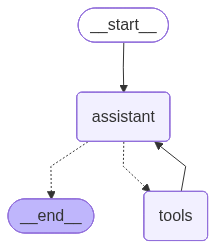

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
!pip install langgraph-checkpoint-sqlite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 4.9 MB/s eta 0:00:00


In [ ]:
import sqlite3

In [ ]:
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

--2025-10-20 11:24:51--  https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db [following]
--2025-10-20 11:24:51--  https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110592 (108K) [application/octet-stream]
Saving to: ‘state_db/example.db’

example.db          100%[===================>] 108.00K  --.-KB/s    in 0.01s   

2025-10-20 11:24:51 (7.33 MB/s) - ‘s

In [ ]:
db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [ ]:
cursor = conn.cursor()

In [ ]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("Tables in the database:")
for table in tables:
    print(table[0])

Tables in the database:
checkpoints
writes


In [ ]:
# Fetch first 5 rows
table_name = "checkpoints"
cursor.execute(f"SELECT * FROM {table_name} LIMIT 5;")
rows = cursor.fetchall()

print(f"\nSample data from {table_name}:")
for row in rows:
    print(row)



Sample data from checkpoints:
('1', '', '1ef64b22-3155-65d8-bfff-cb35a53ab872', None, 'json', b'{"v": 1, "ts": "2024-08-27T20:22:52.733166+00:00", "id": "1ef64b22-3155-65d8-bfff-cb35a53ab872", "channel_values": {"messages": [], "__start__": {"messages": [{"lc": 1, "type": "constructor", "id": ["langchain", "schema", "messages", "HumanMessage"], "kwargs": {"content": "hi! I\'m Lance", "type": "human"}}]}}, "channel_versions": {"__start__": "00000000000000000000000000000001.761a8c54329ca020d4813f3f8164401b"}, "versions_seen": {"__input__": {}}, "pending_sends": [], "current_tasks": {}}', b'{"source": "input", "writes": {"messages": [{"lc": 1, "type": "constructor", "id": ["langchain", "schema", "messages", "HumanMessage"], "kwargs": {"content": "hi! I\'m Lance", "type": "human"}}]}, "step": -1}')
('1', '', '1ef64b22-315d-6eae-8000-a235a23be95b', '1ef64b22-3155-65d8-bfff-cb35a53ab872', 'json', b'{"v": 1, "ts": "2024-08-27T20:22:52.736675+00:00", "id": "1ef64b22-315d-6eae-8000-a235a23be95

In [ ]:
from langgraph.checkpoint.sqlite import SqliteSaver

In [ ]:
memory = SqliteSaver(conn)

In [ ]:
graph = builder.compile(checkpointer=memory)

In [ ]:
config = {"configurable": {"thread_id": "1"}}

input_message = HumanMessage(content="hi! I'm Akash")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello Akash! Nice to meet you. How can I help you today?
================================== Ai Message ==================================

Your name is Akash.
================================== Ai Message ==================================

That’s great to hear! The 49ers have a lot to talk about—whether it’s their current roster, recent games, or the legacy of legends like Jerry Rice and Steve Young. What’s your favorite part about the team? Are you excited about the upcoming season, or do you have a favorite player or memorable game in mind?


In [ ]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='086e80ce-8bd0-4dee-b13c-f47160d6755f'), AIMessage(content="Hello Lance! You've already introduced yourself, but it's nice to greet you again. Is there something specific you'd like to talk about? Perhaps you'd like to continue our conversation about the 49ers, or is there another topic you're interested in discussing?", additional_kwargs={}, response_metadata={'id': 'msg_01AkDF6AH7LMp2YDDD9jQkEC', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 197, 'output_tokens': 58}}, id='run-7f8af5e1-5248-4ccd-ab46-87580422f0d6-0', usage_metadata={'input_tokens': 197, 'output_tokens': 58, 'total_tokens': 255}), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='e33f42ee-cdb0-45ec-b100-54dcd4c82e71'), AIMessage(content="Your name is Lance. You've introduced yourself twice durin